### Importing libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

import requests
from io import StringIO
import powerlaw
import seaborn as sns

import geopandas as gpd
from shapely.geometry import LineString, Point

from community import community_louvain

### Loading/combining dataset and creating network

In [2]:
# Load airports.dat into a DataFrame
airports_url = 'https://raw.githubusercontent.com/ShihaburRahmann/MUSI-11757-Flight-Routes-Analysis/refs/heads/master/data/airports.dat'
airports_df = pd.read_csv(airports_url, header=None, names=[
    "airport_id", "name", "city", "country", "iata", "icao",
    "latitude", "longitude", "altitude", "timezone", "dst",
    "tz_database_timezone", "type", "source"
])

# Ensure airport_id is a string
airports_df['airport_id'] = airports_df['airport_id'].astype(str)

# Load routes.dat into a DataFrame
routes_url = 'https://raw.githubusercontent.com/ShihaburRahmann/MUSI-11757-Flight-Routes-Analysis/refs/heads/master/data/routes.dat'
routes_df = pd.read_csv(routes_url, header=None, names=[
    "airline", "airline_id", "source_airport", "source_airport_id",
    "destination_airport", "destination_airport_id", "codeshare",
    "stops", "equipment"
])

# Ensure source_airport_id and destination_airport_id are strings
routes_df['source_airport_id'] = routes_df['source_airport_id'].astype(str)
routes_df['destination_airport_id'] = routes_df['destination_airport_id'].astype(str)

# Convert routes to undirected format and remove duplicates
routes_df['airport_pair'] = routes_df.apply(
    lambda x: tuple(sorted([x['source_airport_id'], x['destination_airport_id']])), axis=1
)
routes_df = routes_df.drop_duplicates(subset=['airport_pair']).copy()

routes_df[['airport_1_id', 'airport_2_id']] = pd.DataFrame(
    routes_df['airport_pair'].tolist(), index=routes_df.index
)

# Merge coordinates and regions for airport_1
routes_df = routes_df.merge(
    airports_df[['airport_id', 'latitude', 'longitude', 'country']],
    left_on='airport_1_id', right_on='airport_id',
    how='left'
).rename(columns={
    'latitude': 'airport_1_lat', 'longitude': 'airport_1_long', 'country': 'airport_1_country'
}).drop(columns=['airport_id'])

# Merge coordinates and regions for airport_2
routes_df = routes_df.merge(
    airports_df[['airport_id', 'latitude', 'longitude', 'country']],
    left_on='airport_2_id', right_on='airport_id',
    how='left'
).rename(columns={
    'latitude': 'airport_2_lat', 'longitude': 'airport_2_long', 'country': 'airport_2_country'
}).drop(columns=['airport_id'])

# Drop unnecessary columns
routes_df = routes_df.drop(columns=['codeshare', 'stops', 'airport_pair', 'source_airport_id', 'destination_airport_id'])
routes_df.columns = map(str.lower, routes_df.columns)

# Ensure completeness of data (remove rows with missing coordinates)
routes_df = routes_df.dropna(subset=['airport_1_lat', 'airport_1_long', 'airport_2_lat', 'airport_2_long'])
routes_df = routes_df.rename(columns={"source_airport": "airport_1", "destination_airport": "airport_2"})

# Create a graph from the routes DataFrame using IATA codes
G = nx.Graph()

# Add edges to the graph with attributes for analysis
for _, row in routes_df.iterrows():
    
    if row["airport_1"] not in G:
        G.add_node(row["airport_1"], country=row["airport_1_country"])
    if row["airport_2"] not in G:
        G.add_node(row["airport_2"], country=row["airport_2_country"])
        
    G.add_edge(
        row["airport_1"], 
        row["airport_2"],
        airline=row["airline"],
        airport_1_country=row["airport_1_country"],
        airport_2_country=row["airport_2_country"]
    )
print(routes_df.info())

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

<class 'pandas.core.frame.DataFrame'>
Index: 18859 entries, 0 to 19204
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   airline            18859 non-null  object 
 1   airline_id         18859 non-null  object 
 2   airport_1          18859 non-null  object 
 3   airport_2          18859 non-null  object 
 4   equipment          18855 non-null  object 
 5   airport_1_id       18859 non-null  object 
 6   airport_2_id       18859 non-null  object 
 7   airport_1_lat      18859 non-null  float64
 8   airport_1_long     18859 non-null  float64
 9   airport_1_country  18859 non-null  object 
 10  airport_2_lat      18859 non-null  float64
 11  airport_2_long     18859 non-null  float64
 12  airport_2_country  18859 non-null  object 
dtypes: float64(4), object(9)
memory usage: 2.0+ MB
None
Graph has 3214 nodes and 18859 edges.


### Basic network properties

In [3]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
connected_components = list(nx.connected_components(G))
num_connected_components = len(connected_components)
largest_component = max(connected_components, key=len)
subgraph_largest = G.subgraph(largest_component)
average_degree = sum(dict(G.degree()).values()) / num_nodes
diameter = nx.diameter(subgraph_largest)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Number of connected components: {num_connected_components}")
print(f"Average degree: {average_degree:.2f}")
print(f"Diameter: {diameter}")

Number of nodes: 3214
Number of edges: 18859
Number of connected components: 7
Average degree: 11.74
Diameter: 12


### Centrality measures and correlation

Top 5 by Degree Centrality
    Node  Degree Centrality  Closeness Centrality  Eigenvector Centrality
214  AMS           0.077186              0.401883                0.167934
485  FRA           0.075941              0.410920                0.166436
432  CDG           0.074697              0.408320                0.159498
754  IST           0.072518              0.388451                0.129197
189  ATL           0.067538              0.373048                0.081219

Top 5 by Closeness Centrality
    Node  Degree Centrality  Closeness Centrality  Eigenvector Centrality
485  FRA           0.075941              0.410920                0.166436
432  CDG           0.074697              0.408320                0.159498
450  LHR           0.053221              0.405752                0.135963
214  AMS           0.077186              0.401883                0.167934
154  DXB           0.057579              0.400407                0.103488

Top 5 by Eigenvector Centrality
    Node  Degree Cent

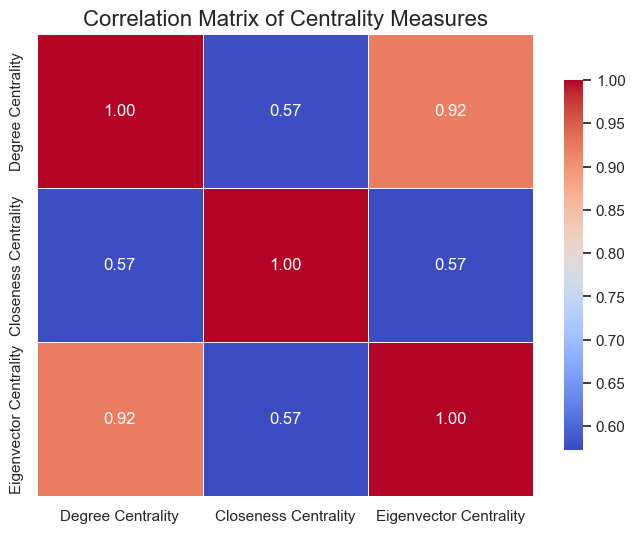

In [4]:
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

centrality_df = pd.DataFrame({
    "Node": list(G.nodes()),
    "Degree Centrality": [degree_centrality[node] for node in G.nodes()],
    "Closeness Centrality": [closeness_centrality[node] for node in G.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality[node] for node in G.nodes()],
})

# Display top 5 nodes by each centrality measure
print("Top 5 by Degree Centrality")
print(centrality_df.nlargest(5, "Degree Centrality"))
print("\nTop 5 by Closeness Centrality")
print(centrality_df.nlargest(5, "Closeness Centrality"))
print("\nTop 5 by Eigenvector Centrality")
print(centrality_df.nlargest(5, "Eigenvector Centrality"))

# Calculate correlation matrix for centrality measures
correlation_matrix = centrality_df[["Degree Centrality", "Closeness Centrality", "Eigenvector Centrality"]].corr()

plt.figure(figsize=(8, 6))
sns.set(style="white")

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Correlation Matrix of Centrality Measures", fontsize=16)
plt.savefig('centrality_corr.png')
plt.show()

### Degree distribution

Calculating best minimal value for power law fit
Power Law Exponent (alpha): 1.8669
Minimum degree: 2.0


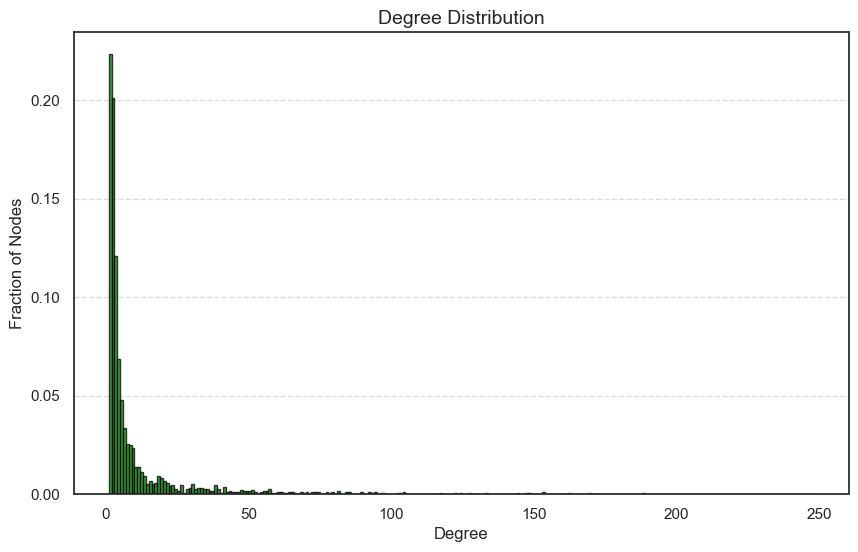

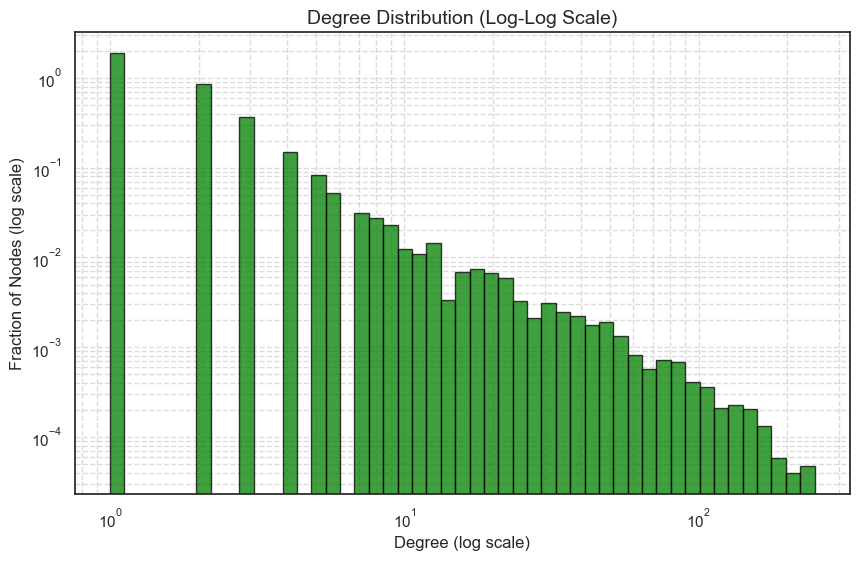

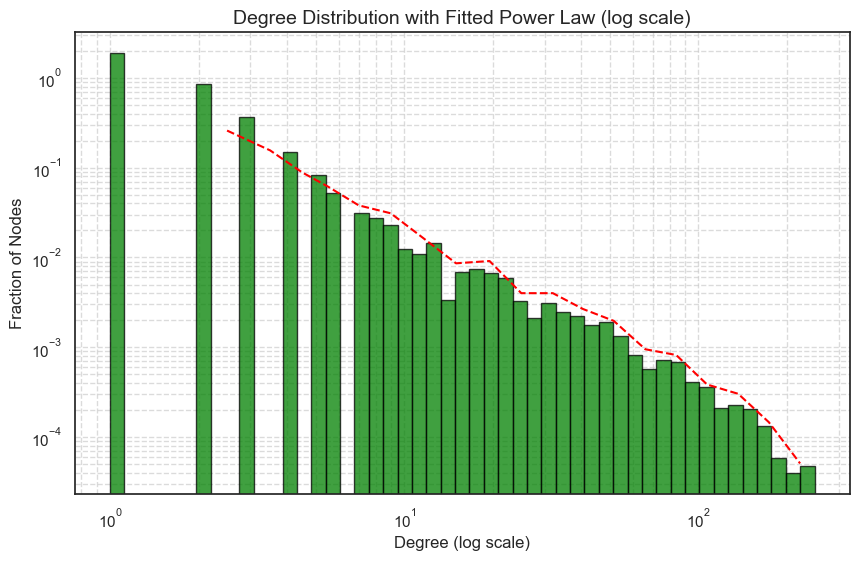

In [5]:
degrees = [degree for _, degree in G.degree()]

# Fit the degree distribution to a power law model
fit = powerlaw.Fit(degrees)

# Get the exponent (alpha) and xmin value
alpha = fit.alpha
xmin = fit.xmin

print(f"Power Law Exponent (alpha): {alpha:.4f}")
print(f"Minimum degree: {xmin}")

# Regular Scale Histogram
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(1, max(degrees) + 1), density=True, alpha=0.75, color='green', edgecolor='black')
plt.title('Degree Distribution', fontsize=14)
plt.xlabel('Degree', fontsize=12)
plt.ylabel('Fraction of Nodes', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Log-Log Scale Histogram
plt.figure(figsize=(10, 6))
log_bins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), num=50)
plt.hist(degrees, bins=log_bins, density=True, alpha=0.75, color='green', edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)', fontsize=14)
plt.xlabel('Degree (log scale)', fontsize=12)
plt.ylabel('Fraction of Nodes (log scale)', fontsize=12)
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.hist(degrees, bins=log_bins, density=True, alpha=0.75, color='green', edgecolor='black')
fit.plot_pdf(color='red', linestyle='--', ax=ax)
plt.title('Degree Distribution with Fitted Power Law (log scale)', fontsize=14)
plt.xlabel('Degree (log scale)', fontsize=12)
plt.ylabel('Fraction of Nodes', fontsize=12)
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.show()

### Assortativity

In [6]:
def calculate_network_assortativity(G):
    degree_assortativity = nx.degree_assortativity_coefficient(G)
    print(f"Degree assortativity coefficient: {degree_assortativity:.4f}")
    
    region_assortativity = nx.attribute_assortativity_coefficient(G, attribute='country')
    print(f"Country assortativity coefficient: {region_assortativity:.4f}")
    
    return degree_assortativity, region_assortativity

degree_assort, region_assort = calculate_network_assortativity(G)

Degree assortativity coefficient: -0.0167
Country assortativity coefficient: 0.3869


### World map representation

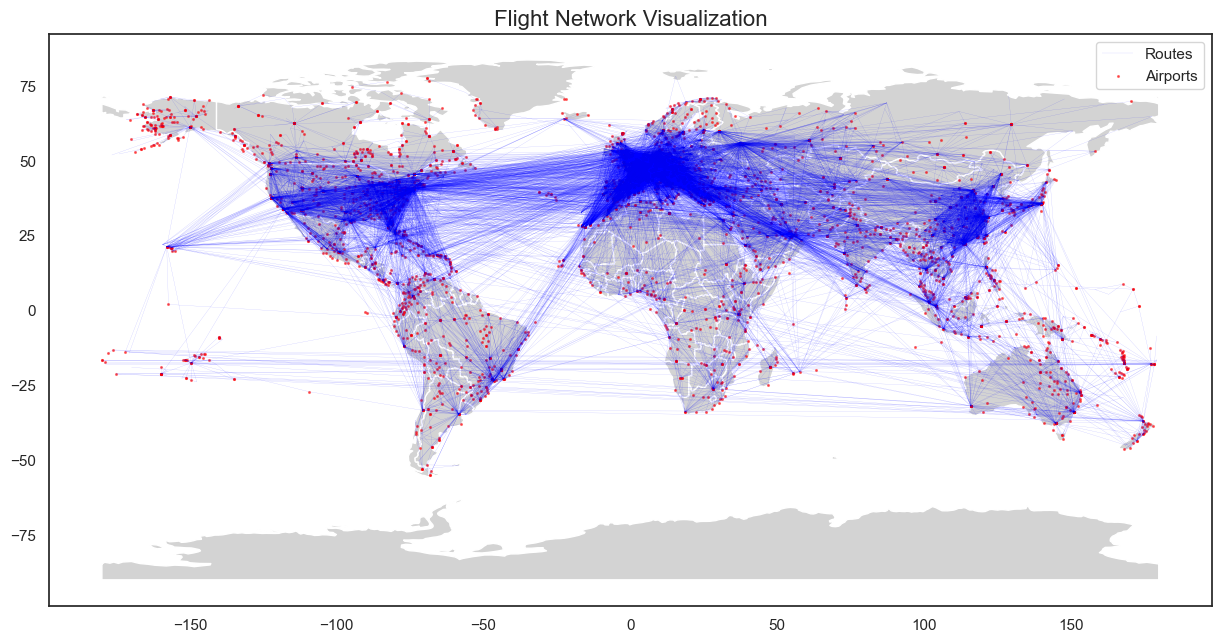

In [7]:
# Load shapefile
world = gpd.read_file("https://github.com/ShihaburRahmann/MUSI-11757-Flight-Routes-Analysis/raw/refs/heads/master/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Ensure 'routes_df' has unique routes
unique_routes_df = routes_df.drop_duplicates(subset=["airport_1", "airport_2"])

# Create geometry for routes
routes_gdf = gpd.GeoDataFrame(
    unique_routes_df,
    geometry=[
        LineString([(row["airport_1_long"], row["airport_1_lat"]), 
                    (row["airport_2_long"], row["airport_2_lat"])])
        for _, row in unique_routes_df.iterrows()
    ],
    crs="EPSG:4326"  
)

# Create geometry for airports
airports_gdf = pd.concat([
    routes_df[["airport_1", "airport_1_lat", "airport_1_long"]].rename(columns={"airport_1": "airport", "airport_1_lat": "lat", "airport_1_long": "long"}),
    routes_df[["airport_2", "airport_2_lat", "airport_2_long"]].rename(columns={"airport_2": "airport", "airport_2_lat": "lat", "airport_2_long": "long"})
]).drop_duplicates(subset=["airport"])
airports_gdf = gpd.GeoDataFrame(
    airports_gdf,
    geometry=gpd.points_from_xy(airports_gdf["long"], airports_gdf["lat"]),
    crs="EPSG:4326"
)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.plot(ax=ax, color="lightgray", edgecolor="white")

# Plot routes
routes_gdf.plot(ax=ax, linewidth=0.15, color="blue", alpha=0.3, label="Routes")

# Plot airports
airports_gdf.plot(ax=ax, color="red", markersize=1.5, alpha=0.5, label="Airports")

ax.set_title("Flight Network Visualization", fontsize=16)
plt.legend()
plt.savefig('world_map.png')
plt.show()

### Random networks construction

In [8]:
# Reference network properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
degree_sequence = [d for _, d in G.degree()]  # Degree sequence of the original network

# Probability for Erdős-Rényi model
p = 2 * num_edges / (num_nodes * (num_nodes - 1))  # Calculate p based on edge density

# Generate 3 ER networks
er_networks = [nx.erdos_renyi_graph(num_nodes, p) for _ in range(3)]

# Generate 7 Configuration Models
cm_networks = [nx.configuration_model(degree_sequence) for _ in range(7)]
cm_networks = [nx.Graph(cm) for cm in cm_networks]

### Random networks degree distribution

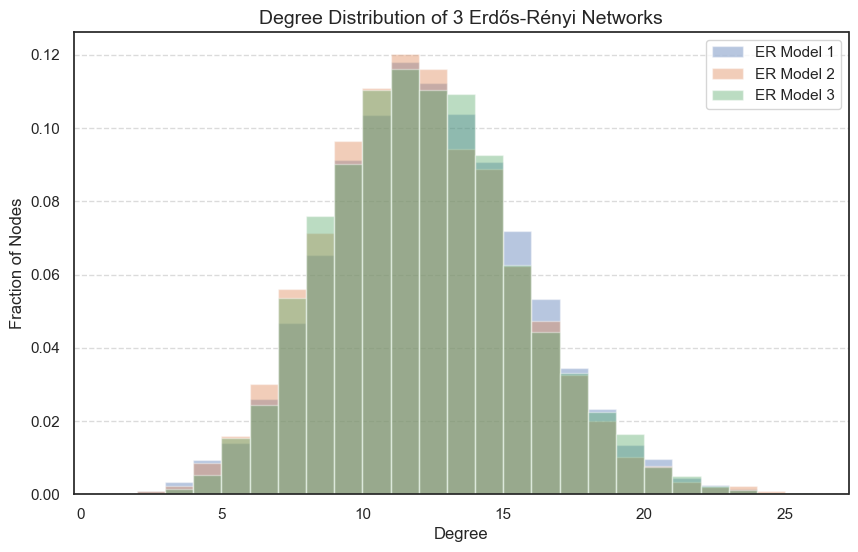

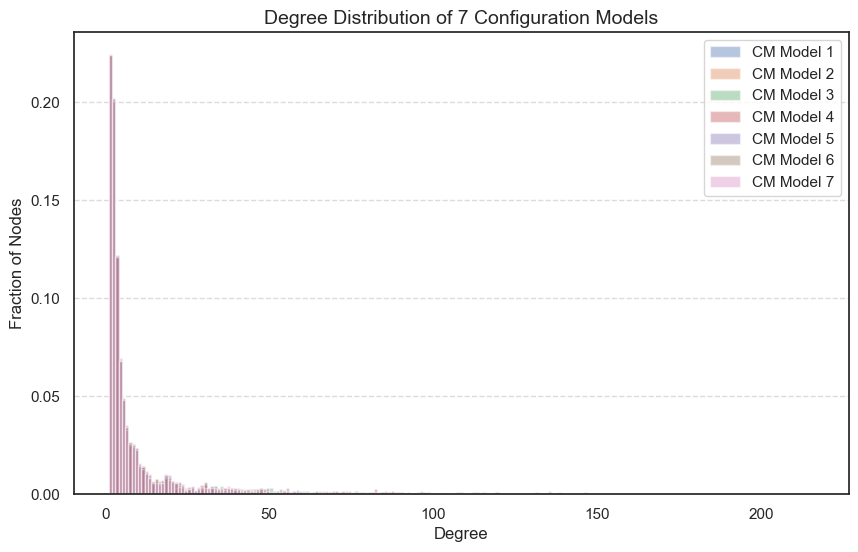

In [9]:
# Function to plot degree distribution
def plot_degree_distribution(networks, title, color, label_prefix):
    plt.figure(figsize=(10, 6))
    for i, net in enumerate(networks, start=1):
        degrees = [d for _, d in net.degree()]
        plt.hist(degrees, bins=range(1, max(degrees) + 1), alpha=0.4, label=f"{label_prefix} {i}", density=True)
    plt.title(title, fontsize=14)
    plt.xlabel("Degree", fontsize=12)
    plt.ylabel("Fraction of Nodes", fontsize=12)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Plot ER degree distributions
plot_degree_distribution(er_networks, "Degree Distribution of 3 Erdős-Rényi Networks", color="blue", label_prefix="ER Model")

# Plot CM degree distributions
plot_degree_distribution(cm_networks, "Degree Distribution of 7 Configuration Models", color="green", label_prefix="CM Model")

### Centrality measures comparison


Average Degree Centrality:
Reference Network: 0.0037
Erdős-Rényi Networks: 0.0036
Configuration Model Networks: 0.0035


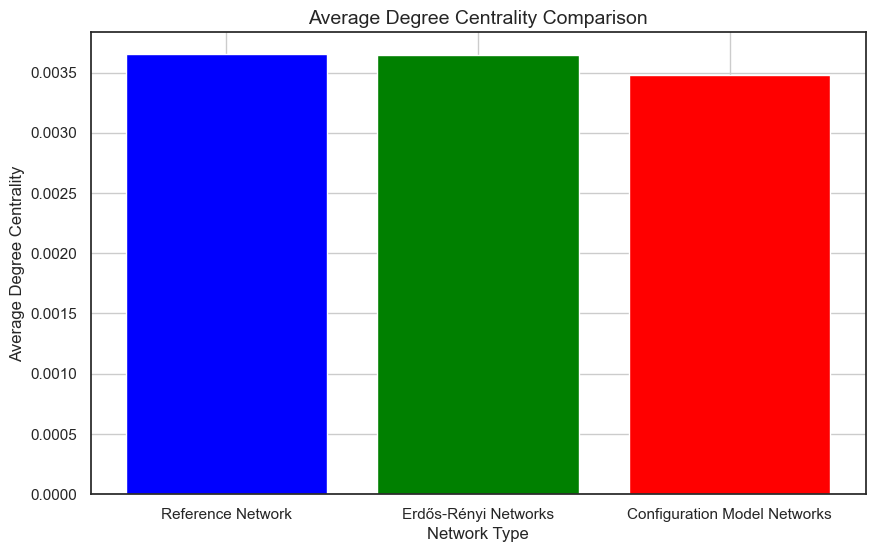


Average Closeness Centrality:
Reference Network: 0.2554
Erdős-Rényi Networks: 0.2811
Configuration Model Networks: 0.3033


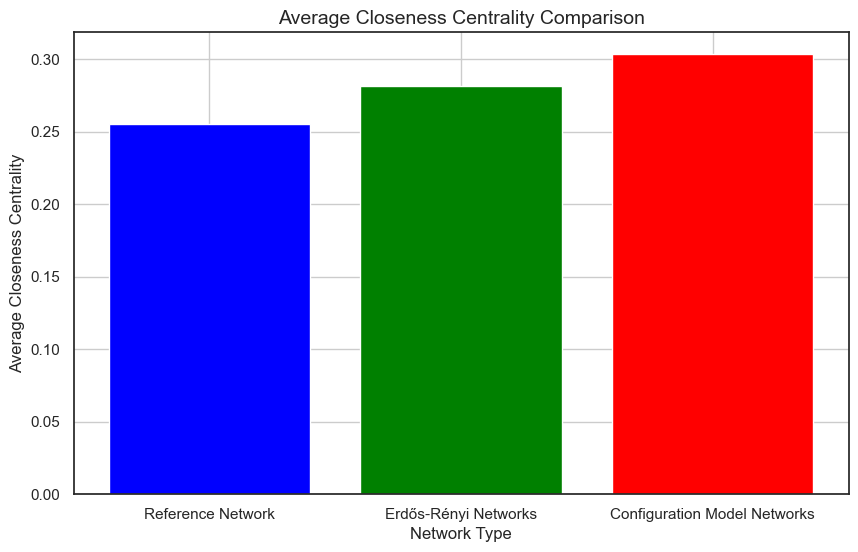


Average Eigenvector Centrality:
Reference Network: 0.0065
Erdős-Rényi Networks: 0.0167
Configuration Model Networks: 0.0080


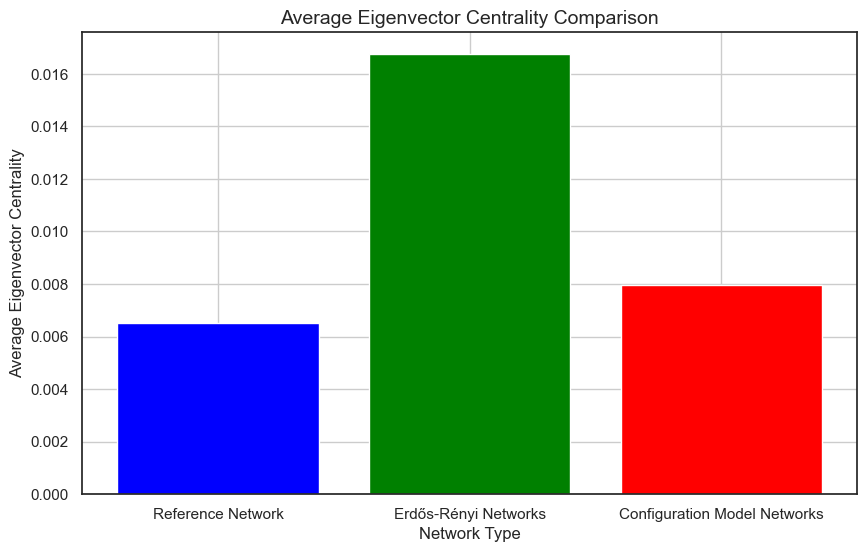


Average Clustering Coefficient:
Reference Network: 0.4918
Erdős-Rényi Networks: 0.0036
Configuration Model Networks: 0.0699


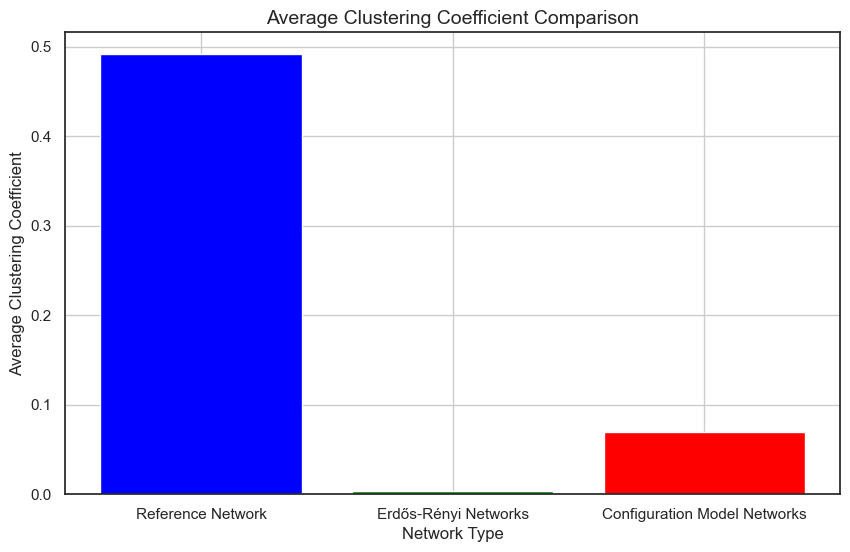

In [10]:
def calculate_centralities(G):
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    
    return degree_centrality, closeness_centrality, eigenvector_centrality

degree_centrality_ref, closeness_centrality_ref, eigenvector_centrality_ref = calculate_centralities(G)

# Calculate centralities for Erdős–Rényi and Configuration Model networks
degree_centrality_er, closeness_centrality_er, eigenvector_centrality_er =[], [], []
degree_centrality_cm, closeness_centrality_cm, eigenvector_centrality_cm =[], [], []

for er_net in er_networks:
    dc, cc, ec = calculate_centralities(er_net)
    degree_centrality_er.append(dc)
    closeness_centrality_er.append(cc)
    eigenvector_centrality_er.append(ec)

for cm_net in cm_networks:
    dc, cc, ec = calculate_centralities(cm_net)
    degree_centrality_cm.append(dc)
    closeness_centrality_cm.append(cc)
    eigenvector_centrality_cm.append(ec)


# Function to plot Bar Chart for average centrality comparison
def plot_bar_chart_centrality(reference_centrality, er_centralities, cm_centralities, centrality_name):
    # Calculate average centrality values for each network type
    ref_avg = np.mean(list(reference_centrality.values()))
    er_avg = np.mean([np.mean(list(er.values())) for er in er_centralities])
    cm_avg = np.mean([np.mean(list(cm.values())) for cm in cm_centralities])

    print(f"\nAverage {centrality_name}:")
    print(f"Reference Network: {ref_avg:.4f}")
    print(f"Erdős-Rényi Networks: {er_avg:.4f}")
    print(f"Configuration Model Networks: {cm_avg:.4f}")

    labels = ['Reference Network', 'Erdős-Rényi Networks', 'Configuration Model Networks']
    values = [ref_avg, er_avg, cm_avg]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'green', 'red'])
    plt.title(f"Average {centrality_name} Comparison", fontsize=14)
    plt.xlabel("Network Type", fontsize=12)
    plt.ylabel(f"Average {centrality_name}", fontsize=12)
    plt.grid(True)
    plt.show()

# Plot Degree Centrality Bar Chart
plot_bar_chart_centrality(degree_centrality_ref, degree_centrality_er, degree_centrality_cm, "Degree Centrality")

# Plot Closeness Centrality Bar Chart
plot_bar_chart_centrality(closeness_centrality_ref, closeness_centrality_er, closeness_centrality_cm, "Closeness Centrality")

# Plot Eigenvector Centrality Bar Chart
plot_bar_chart_centrality(eigenvector_centrality_ref, eigenvector_centrality_er, eigenvector_centrality_cm, "Eigenvector Centrality")

# Function to calculate average clustering coefficients
def calculate_average_clustering(networks):
    return [np.mean(list(nx.clustering(net).values())) for net in networks]

# Calculate average clustering coefficients for each network type
ref_clustering_avg = np.mean(list(nx.clustering(G).values()))
er_clustering_avg = calculate_average_clustering(er_networks)
cm_clustering_avg = calculate_average_clustering(cm_networks)

# Function to plot bar chart for clustering coefficient comparison
def plot_bar_chart_clustering(ref_clustering, er_clustering, cm_clustering):
    # Calculate average clustering coefficients
    er_avg = np.mean(er_clustering)
    cm_avg = np.mean(cm_clustering)

    print("\nAverage Clustering Coefficient:")
    print(f"Reference Network: {ref_clustering:.4f}")
    print(f"Erdős-Rényi Networks: {er_avg:.4f}")
    print(f"Configuration Model Networks: {cm_avg:.4f}")

    labels = ['Reference Network', 'Erdős-Rényi Networks', 'Configuration Model Networks']
    values = [ref_clustering, er_avg, cm_avg]

    plt.figure(figsize=(10, 6))
    plt.bar(labels, values, color=['blue', 'green', 'red'])
    plt.title("Average Clustering Coefficient Comparison", fontsize=14)
    plt.xlabel("Network Type", fontsize=12)
    plt.ylabel("Average Clustering Coefficient", fontsize=12)
    plt.grid(True)
    plt.show()

plot_bar_chart_clustering(ref_clustering_avg, er_clustering_avg, cm_clustering_avg)

### Louvain community detection

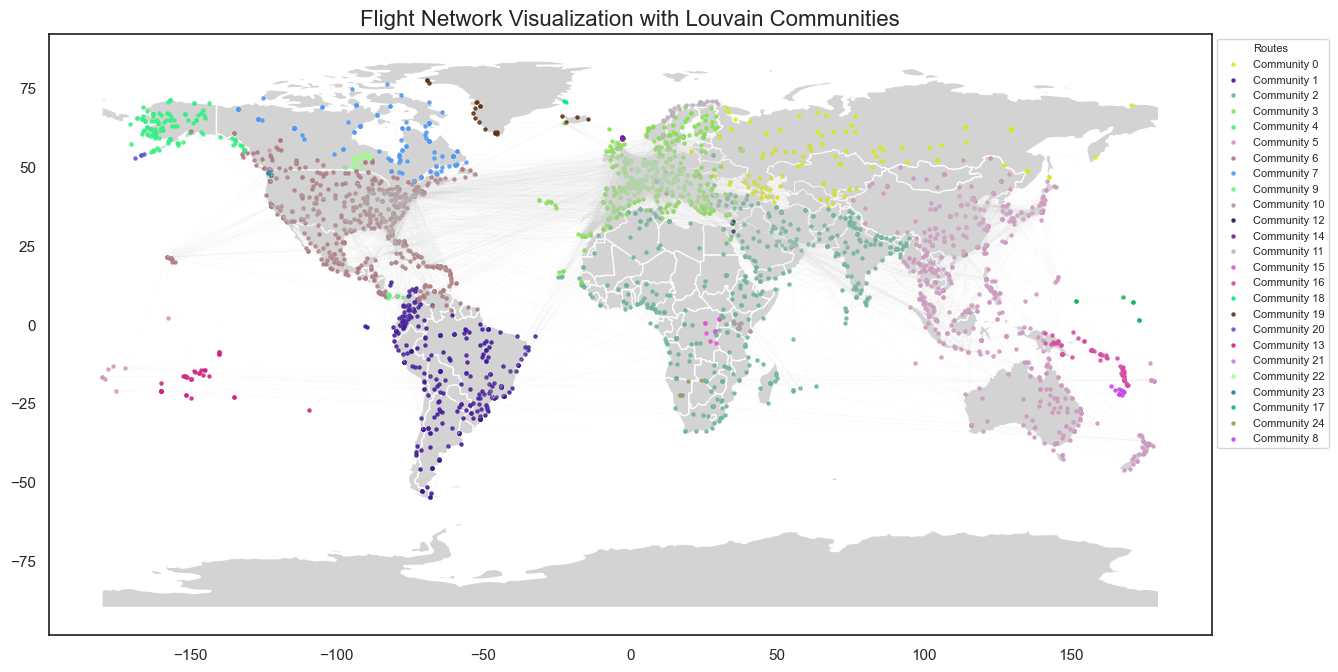

In [11]:
world = gpd.read_file("https://github.com/ShihaburRahmann/MUSI-11757-Flight-Routes-Analysis/raw/refs/heads/master/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

unique_routes_df = routes_df.drop_duplicates(subset=["airport_1", "airport_2"])

# Create geometry for routes
routes_gdf = gpd.GeoDataFrame(
    unique_routes_df,
    geometry=[
        LineString([(row["airport_1_long"], row["airport_1_lat"]), 
                    (row["airport_2_long"], row["airport_2_lat"])])
        for _, row in unique_routes_df.iterrows()
    ],
    crs="EPSG:4326"
)

# Create geometry for airports
airports_df = pd.concat([
    routes_df[["airport_1", "airport_1_lat", "airport_1_long"]].rename(columns={"airport_1": "airport", "airport_1_lat": "lat", "airport_1_long": "long"}),
    routes_df[["airport_2", "airport_2_lat", "airport_2_long"]].rename(columns={"airport_2": "airport", "airport_2_lat": "lat", "airport_2_long": "long"})
]).drop_duplicates(subset=["airport"])
airports_gdf = gpd.GeoDataFrame(
    airports_df,
    geometry=gpd.points_from_xy(airports_df["long"], airports_df["lat"]),
    crs="EPSG:4326"
)

routes_gdf = routes_gdf[routes_gdf.is_valid & ~routes_gdf.is_empty]
airports_gdf = airports_gdf[airports_gdf.is_valid & ~airports_gdf.is_empty]

# Perform Louvain Community Detection
partition = community_louvain.best_partition(G)

nx.set_node_attributes(G, partition, "community")

airports_gdf["community"] = airports_gdf["airport"].map(partition)

# Generate random colors for communities
unique_communities = airports_gdf["community"].dropna().unique()
community_colors = {community: f"#{random.randint(0, 0xFFFFFF):06x}" for community in unique_communities}

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.plot(ax=ax, color="lightgray", edgecolor="white")
routes_gdf.plot(ax=ax, linewidth=0.1, color="lightgray", alpha=0.2, label="Routes")

# Plot airports with community colors
for community, color in community_colors.items():
    airports_gdf[airports_gdf["community"] == community].plot(
        ax=ax,
        color=color,
        markersize=5,
        alpha=0.8,
        label=f"Community {community}"
    )

ax.set_title("Flight Network Visualization with Louvain Communities", fontsize=16)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.savefig('louvain.png')
plt.show()

### Communities comparison

In [12]:
def detect_communities(graph):
    # Partition nodes into communities
    partition = community_louvain.best_partition(graph)
    modularity = community_louvain.modularity(partition, graph)
    community_sizes = [list(partition.values()).count(c) for c in set(partition.values())]
    return partition, modularity, community_sizes

# Apply Louvain to the reference network
ref_partition, ref_modularity, ref_community_sizes = detect_communities(G)

# Apply Louvain to 3 ER networks
er_modularities = []
er_community_sizes = []
for i, er_net in enumerate(er_networks, start=1):
    partition, modularity, community_sizes = detect_communities(er_net)
    er_modularities.append(modularity)
    er_community_sizes.append(community_sizes)
    print(f"ER Network {i}: Modularity = {modularity:.4f}, Community Sizes = {community_sizes}")

# Apply Louvain to 7 CM networks
cm_modularities = []
cm_community_sizes = []
for i, cm_net in enumerate(cm_networks, start=1):
    partition, modularity, community_sizes = detect_communities(cm_net)
    cm_modularities.append(modularity)
    cm_community_sizes.append(community_sizes)
    print(f"CM Network {i}: Modularity = {modularity:.4f}, Community Sizes = {community_sizes}")

ER Network 1: Modularity = 0.2551, Community Sizes = [482, 408, 279, 201, 377, 297, 349, 27, 222, 116, 280, 176]
ER Network 2: Modularity = 0.2533, Community Sizes = [241, 326, 415, 249, 519, 76, 412, 1, 296, 195, 133, 183, 57, 111]
ER Network 3: Modularity = 0.2494, Community Sizes = [244, 316, 188, 247, 450, 217, 216, 54, 202, 196, 21, 225, 77, 156, 110, 188, 107]
CM Network 1: Modularity = 0.2323, Community Sizes = [199, 453, 503, 149, 159, 317, 194, 213, 196, 45, 104, 236, 129, 153, 114, 2, 39, 2, 1, 2, 2, 2]
CM Network 2: Modularity = 0.2288, Community Sizes = [300, 310, 127, 345, 154, 54, 219, 304, 450, 121, 250, 2, 73, 49, 28, 293, 123, 2, 2, 2, 2, 2, 2]
CM Network 3: Modularity = 0.2309, Community Sizes = [190, 136, 345, 233, 77, 116, 283, 361, 336, 129, 124, 219, 144, 76, 2, 127, 153, 151, 2, 2, 2, 2, 2, 2]
CM Network 4: Modularity = 0.2313, Community Sizes = [366, 406, 125, 2, 452, 184, 124, 174, 2, 169, 217, 49, 124, 175, 159, 126, 2, 2, 166, 188, 2]
CM Network 5: Modularity

Modularity Scores:
Reference: 0.6585
ER 1: 0.2551
ER 2: 0.2533
ER 3: 0.2494
CM 1: 0.2323
CM 2: 0.2288
CM 3: 0.2309
CM 4: 0.2313
CM 5: 0.2279
CM 6: 0.2278
CM 7: 0.2306


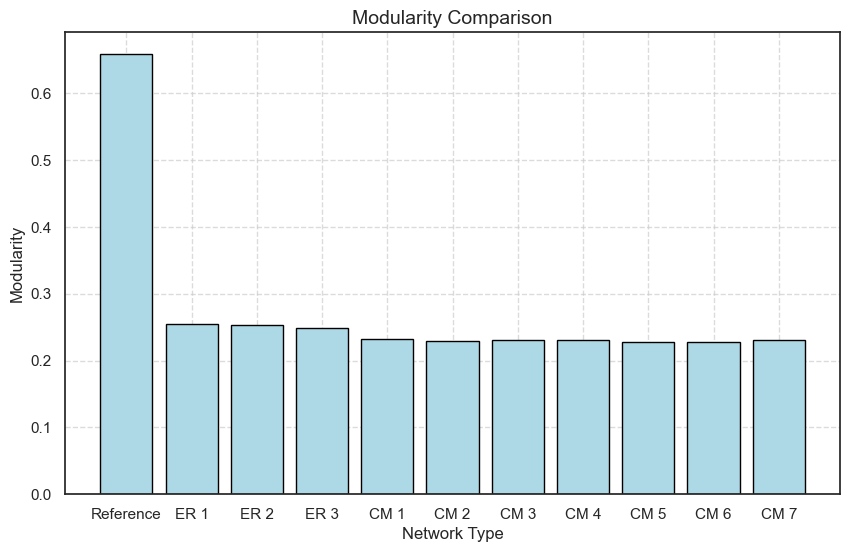


Average Community Sizes:
Reference: 133.92
ER 1: 267.83
ER 2: 229.57
ER 3: 189.06
CM 1: 146.09
CM 2: 139.74
CM 3: 133.92
CM 4: 153.05
CM 5: 139.74
CM 6: 146.09
CM 7: 123.62


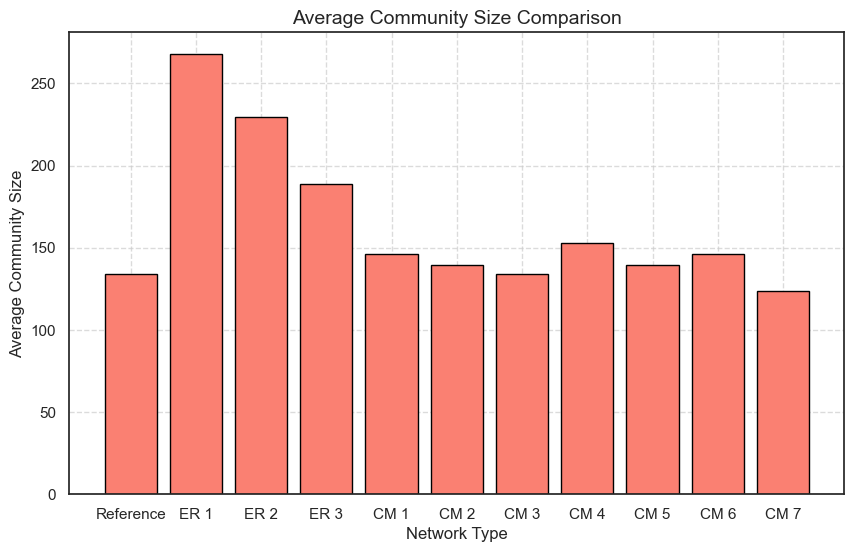


Number of Communities:
Reference: 24
ER 1: 12
ER 2: 14
ER 3: 17
CM 1: 22
CM 2: 23
CM 3: 24
CM 4: 21
CM 5: 23
CM 6: 22
CM 7: 26


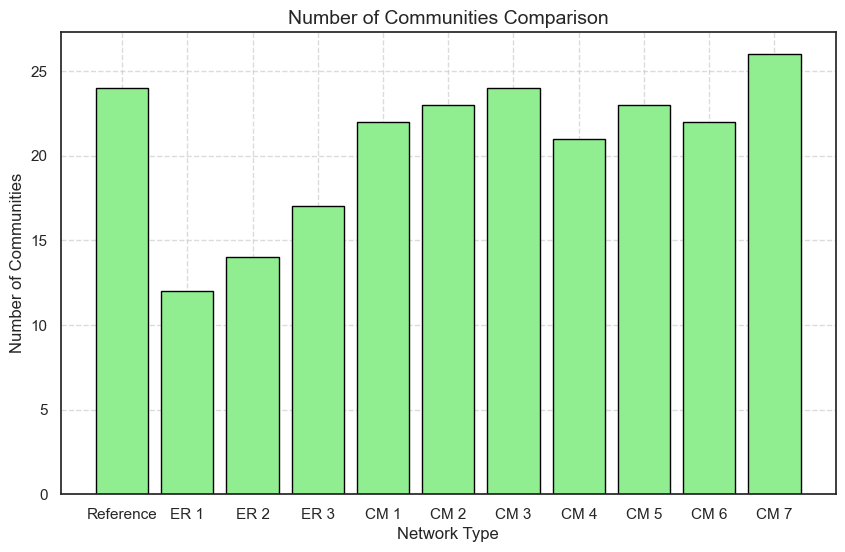

In [13]:
def plot_modularity_comparison(modularities, labels, title="Modularity Comparison"):
    print(f"Modularity Scores:")
    for label, modularity in zip(labels, modularities):
        print(f"{label}: {modularity:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, modularities, color='lightblue', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel("Network Type", fontsize=12)
    plt.ylabel("Modularity", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Combine modularity scores for comparison
modularities = [ref_modularity] + er_modularities + cm_modularities
labels = ["Reference"] + [f"ER {i+1}" for i in range(len(er_community_sizes))] + [f"CM {i+1}" for i in range(len(cm_community_sizes))]

plot_modularity_comparison(modularities, labels)

def plot_avg_community_size_comparison(community_sizes, labels, title="Average Community Size Comparison"):
    avg_sizes = [np.mean(sizes) for sizes in community_sizes]
    print(f"\nAverage Community Sizes:")
    for label, avg_size in zip(labels, avg_sizes):
        print(f"{label}: {avg_size:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, avg_sizes, color='salmon', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel("Network Type", fontsize=12)
    plt.ylabel("Average Community Size", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Combine community sizes for comparison
community_sizes_list = [ref_community_sizes] + er_community_sizes + cm_community_sizes

plot_avg_community_size_comparison(community_sizes_list, labels)

def plot_num_communities_comparison(community_sizes, labels, title="Number of Communities Comparison"):
    num_communities = [len(sizes) for sizes in community_sizes]
    print(f"\nNumber of Communities:")
    for label, num in zip(labels, num_communities):
        print(f"{label}: {num}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, num_communities, color='lightgreen', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel("Network Type", fontsize=12)
    plt.ylabel("Number of Communities", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

plot_num_communities_comparison(community_sizes_list, labels)


### Percolation

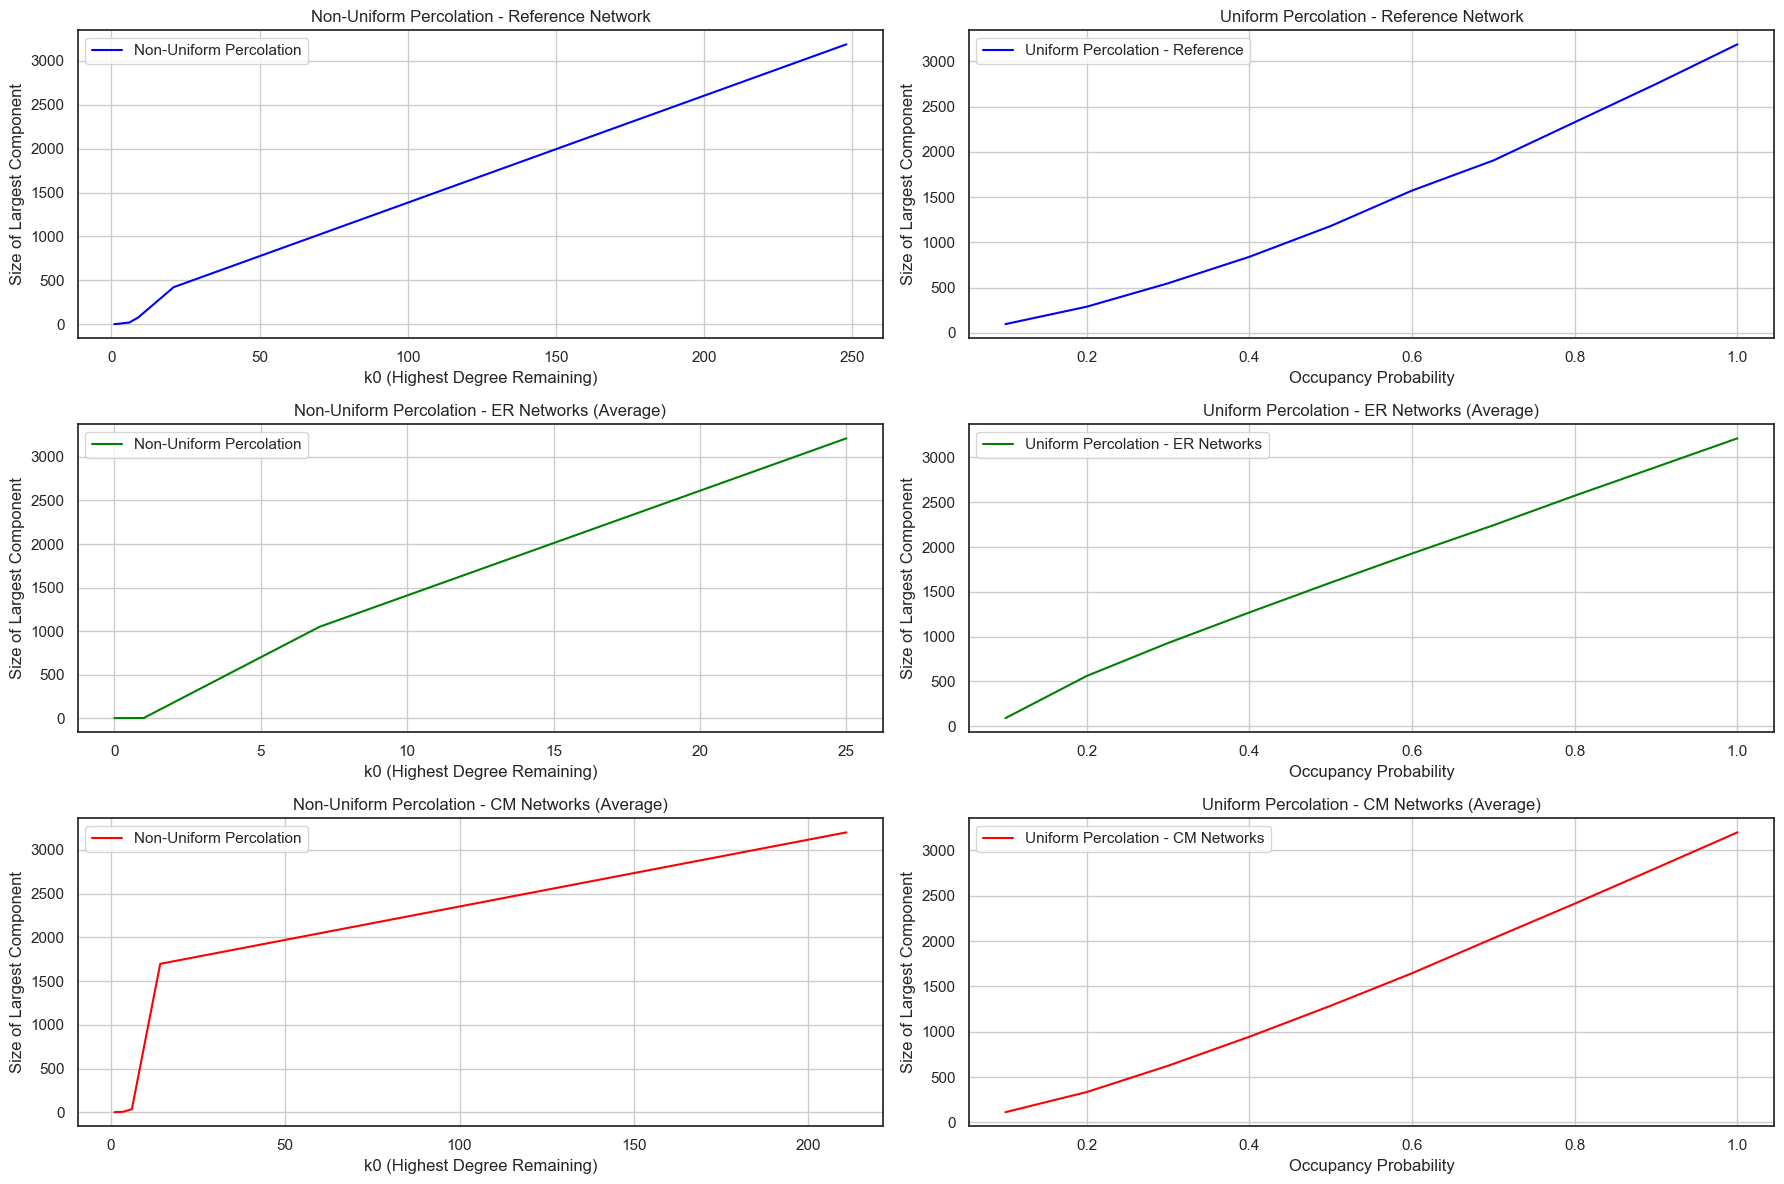

In [14]:
# Helper Functions
def largest_component_size(G):
    components = list(nx.connected_components(G))
    if components:
        largest_component = max(components, key=len)
        return len(largest_component)
    return 0

def uniform_percolation(G, occupancy_probability):
    G_copy = G.copy()
    nodes_to_remove = [node for node in G_copy.nodes if np.random.rand() > occupancy_probability]
    G_copy.remove_nodes_from(nodes_to_remove)
    return largest_component_size(G_copy)

def simulate_uniform_percolation(G, prob_range):
    largest_components = []
    for prob in prob_range:
        component_sizes = [uniform_percolation(G, prob) for _ in range(20)]
        largest_components.append(np.mean(component_sizes))
    return largest_components

def non_uniform_percolation_k0(G, degree_threshold):
    G_copy = G.copy()
    nodes_to_remove = [node for node, degree in dict(G_copy.degree()).items() if degree > degree_threshold]
    G_copy.remove_nodes_from(nodes_to_remove)
    largest_comp_size = largest_component_size(G_copy)
    k0 = max(dict(G_copy.degree()).values(), default=0)
    return largest_comp_size, k0

def simulate_non_uniform_percolation_k0(G, degree_thresholds):
    results = []
    for degree_threshold in degree_thresholds:
        simulations = [non_uniform_percolation_k0(G, degree_threshold) for _ in range(20)]
        avg_size = np.mean([result[0] for result in simulations])
        avg_k0 = np.mean([result[1] for result in simulations])
        results.append((avg_size, avg_k0))
    return results

def extract_sizes_and_k0(results):
    sizes = [result[0] for result in results]
    k0_values = [result[1] for result in results]
    return sizes, k0_values

def plot_non_uniform_percolation_k0(k0_values, sizes, title, plot_index, color):
    plt.subplot(3, 2, plot_index)
    plt.plot(k0_values, sizes, label="Non-Uniform Percolation", color=color)
    plt.xlabel("k0 (Highest Degree Remaining)")
    plt.ylabel("Size of Largest Component")
    plt.title(title)
    plt.grid(True)
    plt.legend()

# Parameters
prob_range = np.linspace(0.1, 1.0, 10)  # Occupancy probabilities
degrees = [d for _, d in G.degree()]
threshold_percentiles = np.linspace(0, 100, 10)
degree_thresholds = np.percentile(degrees, threshold_percentiles)

# Simulations
uniform_results_ref = simulate_uniform_percolation(G, prob_range)
non_uniform_results_ref = simulate_non_uniform_percolation_k0(G, degree_thresholds)

uniform_results_er = [simulate_uniform_percolation(er_network, prob_range) for er_network in er_networks]
non_uniform_results_er = [simulate_non_uniform_percolation_k0(er_network, degree_thresholds) for er_network in er_networks]

uniform_results_cm = [simulate_uniform_percolation(cm_network, prob_range) for cm_network in cm_networks]
non_uniform_results_cm = [simulate_non_uniform_percolation_k0(cm_network, degree_thresholds) for cm_network in cm_networks]

# Extract sizes and k0 values
ref_sizes, ref_k0 = extract_sizes_and_k0(non_uniform_results_ref)

er_sizes_k0 = [extract_sizes_and_k0(results) for results in non_uniform_results_er]
er_avg_sizes = np.mean([sizes for sizes, _ in er_sizes_k0], axis=0)
er_avg_k0 = np.mean([k0 for _, k0 in er_sizes_k0], axis=0)

cm_sizes_k0 = [extract_sizes_and_k0(results) for results in non_uniform_results_cm]
cm_avg_sizes = np.mean([sizes for sizes, _ in cm_sizes_k0], axis=0)
cm_avg_k0 = np.mean([k0 for _, k0 in cm_sizes_k0], axis=0)

# Plotting Results
plt.figure(figsize=(18, 12))

# Reference Network
plot_non_uniform_percolation_k0(ref_k0, ref_sizes, "Non-Uniform Percolation - Reference Network", 1, "blue")
plt.subplot(3, 2, 2)
plt.plot(prob_range, uniform_results_ref, label="Uniform Percolation - Reference", color="blue")
plt.xlabel("Occupancy Probability")
plt.ylabel("Size of Largest Component")
plt.title("Uniform Percolation - Reference Network")
plt.grid(True)
plt.legend()

# ER Networks (Average)
plot_non_uniform_percolation_k0(er_avg_k0, er_avg_sizes, "Non-Uniform Percolation - ER Networks (Average)", 3, "green")
plt.subplot(3, 2, 4)
plt.plot(prob_range, np.mean(uniform_results_er, axis=0), label="Uniform Percolation - ER Networks", color="green")
plt.xlabel("Occupancy Probability")
plt.ylabel("Size of Largest Component")
plt.title("Uniform Percolation - ER Networks (Average)")
plt.grid(True)
plt.legend()

# CM Networks (Average)
plot_non_uniform_percolation_k0(cm_avg_k0, cm_avg_sizes, "Non-Uniform Percolation - CM Networks (Average)", 5, "red")
plt.subplot(3, 2, 6)
plt.plot(prob_range, np.mean(uniform_results_cm, axis=0), label="Uniform Percolation - CM Networks", color="red")
plt.xlabel("Occupancy Probability")
plt.ylabel("Size of Largest Component")
plt.title("Uniform Percolation - CM Networks (Average)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


### Export to Gephi readable format

In [15]:
# nx.write_gexf(G, "network_gephi.gexf")

# print("Network has been exported to 'network_gephi.gexf' for use in Gephi.")

*Note: Some results might be different, especially for random networks, since the random seed is not set.*